In [15]:
using DataFrames, CSV
using Convex, ECOS  # Convex modeling and solver
using Distributions, Random  # Seeds and sampling
using LightGraphs  # Generating nice random graphs
using Plots, Colors, GraphRecipes  # For plottig

using Revise
using CarbonNetworks

# Load data

## Load network

In [181]:
A, gmax, pmax, f, G, nodes = parse_network_data()
n = length(gmax)
m = length(pmax)

@show n, m;

(n, m) = (684, 775)


## Load case

In [5]:
df_elec = DataFrame(CSV.File(CarbonNetworks.get_data_path("EBA_elec.csv")))
rename!(df_elec, "Column1" => "date")

filter(wrd -> occursin("CISO-ALL", wrd), names(df_elec))[1:5]

5-element Vector{String}:
 "EBA.CISO-ALL.D.H"
 "EBA.CISO-ALL.NG.BIO.H"
 "EBA.CISO-ALL.NG.COL.H"
 "EBA.CISO-ALL.NG.GEO.H"
 "EBA.CISO-ALL.NG.H"

In [231]:
df_case = filter(r -> r.date == "2018-08-20 18:00:00+00:00", df_elec)

bas = unique([n[2] for n in nodes])
demands = zeros(length(bas))
wnd = ba -> "EBA.$(ba)-ALL.NG.WND.H"
sun = ba -> "EBA.$(ba)-ALL.NG.SUN.H"

for (ind, ba) in enumerate(bas)
    demands[ind] += coalesce(df_case[1, "EBA.$(ba)-ALL.D.H"], 0.0)
    demands[ind] -= wnd(ba) in names(df_case) ? df_case[1, wnd(ba)] : 0.0
    demands[ind] -= sun(ba) in names(df_case) ? df_case[1, sun(ba)] : 0.0
end

d = zeros(n)
for (ind, ba) in enumerate(bas)
    ind_d = findfirst(x -> x[2:3] == (ba, "DEMAND"), nodes)
    d[ind_d] = demands[ind]
end

@show minimum(d)

@show sum(d);

minimum(d) = -80.59152207989037
sum(d) = 519108.9274258927


# Let's solve the carbon minimization problem

In [232]:
g = Variable(n)
p = Variable(m)


p̅ = copy(pmax)
#p̅ *= 0.1
p̅[p̅ .== Inf] .= maximum(gmax)


problem = minimize(f'g)
add_constraints!(problem, abs(p) <= p̅)
add_constraints!(problem, [0 <= g])
add_constraints!(problem, [g <= gmax])
add_constraints!(problem, d - g == A*p)

solve!(problem, () -> ECOS.Optimizer(verbose=false))

g = evaluate(g)
p = evaluate(p)
;

In [233]:
@show sum(abs.(p[primary_edges])) / sum(d)
;

sum(abs.(p[primary_edges])) / sum(d) = 0.05533589021315506


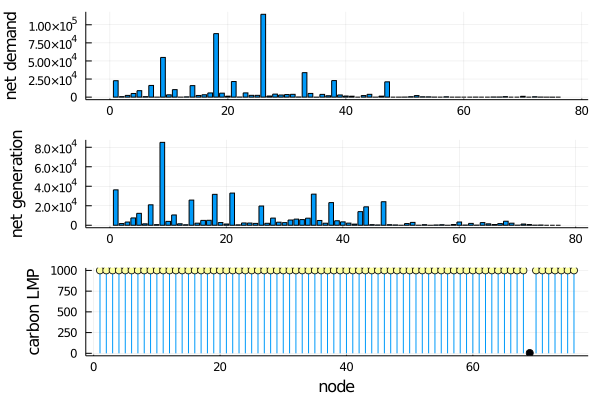

In [234]:
primary_nodes = [ind for (ind, iso, res) in nodes if res == "DEMAND"]
primary_edges = [ind
    for (ind, e) in enumerate(edges(G)) 
        if e.src in primary_nodes && e.dst in primary_nodes]

ν = problem.constraints[4].dual[:, 1]
ν = -ν[primary_nodes]
d_primary = d[primary_nodes]

push!(primary_nodes, lastindex(g))
g_primary = [sum(g[[tup[2] == nodes[i][2] for tup in nodes]]) for i in primary_nodes]
pop!(primary_nodes)

gradient = cgrad(:inferno)
lmp_colors = [get(gradient, νi/maximum(ν)) for νi in ν]

plt1 = bar(d_primary, label=nothing, ylabel="net demand")
plt2 = bar(g_primary, label=nothing, ylabel="net generation")
plt3 = sticks(ν, label=nothing, ylabel="carbon LMP", xlabel="node")
scatter!(plt3, ν, c=lmp_colors, label=nothing)

plot(plt1, plt2, plt3, layout=(3, 1))